In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow_addons.metrics import MatthewsCorrelationCoefficient
import tensorflow as tf
from utils import resnet20
import numpy as np
from tqdm import tqdm
import os

In [84]:
IMAGE_SHAPE = [64, 64, 3]
PROJECTOR_DIMENSIONALITY = 1024
RANDOM_SEED = 42
BATCH_SIZE = 32

TEST_DIR = 'NuCLS_64_7/test'
MODEL_PATH = 'benchmarks/barlow_0.2.h5'  # 'benchmarks/barlow_0.1.h5'
CLASSES = os.listdir(TEST_DIR)


datagen_test = ImageDataGenerator()
datagen_test = datagen_test.flow_from_directory(
    TEST_DIR, seed=RANDOM_SEED, target_size=IMAGE_SHAPE[:2], batch_size=BATCH_SIZE
)

X, y = next(datagen_test)

Found 4969 images belonging to 7 classes.


In [85]:
resnet_enc = resnet20.get_network(
    hidden_dim=PROJECTOR_DIMENSIONALITY,
    use_pred=False,
    return_before_head=False,
    input_shape=IMAGE_SHAPE
)

inputs = Input(IMAGE_SHAPE)
x = resnet_enc(inputs)
if 'barlow' in MODEL_PATH:
    resnet_enc.trainable = False
x = Dense(7, activation='softmax', kernel_initializer='he_normal')(x)
model = Model(inputs=inputs, outputs=x)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'acc',
        tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="top_2_accuracy"),
        MatthewsCorrelationCoefficient(num_classes=len(CLASSES), name='MCC')
    ]
)
model.load_weights(MODEL_PATH)

In [86]:
test_loss, test_acc, test_top_2_acc, test_MCC = model.evaluate(datagen_test)

156/156 [==============================] - 3s 17ms/step - loss: 8.0815 - acc: 0.6297 - top_2_accuracy: 0.7835 - MCC: 0.4211


In [87]:
all_labels = []
all_preds = []

for idx in tqdm(range(len(datagen_test))):
    X, labels = next(datagen_test)
    preds = model.predict(X)
    
    labels = np.argmax(labels, axis=-1)
    preds = np.argmax(preds, axis=-1)
    
    all_labels.extend(labels)
    all_preds.extend(preds)
    
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 19.71it/s]


In [88]:
np.sum(all_labels == all_preds) / len(all_labels)

0.6303079090360233

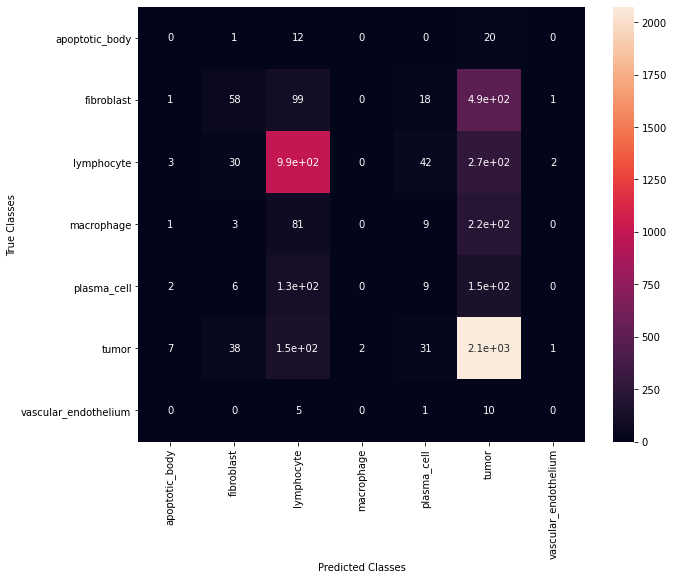

In [89]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from seaborn import heatmap
import pandas as pd

confusion_matrix = confusion_matrix(all_labels, all_preds).astype('int32')
confusion_matrix = pd.DataFrame(confusion_matrix, columns=CLASSES, index=CLASSES)
# confusion_matrix.set_index(CLASSES)

plt.figure(figsize=(10,8))
heatmap(confusion_matrix, annot=True)
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.show()

In [70]:
classes_map = datagen_test.class_indices

{'apoptotic_body': 0,
 'fibroblast': 1,
 'lymphocyte': 2,
 'macrophage': 3,
 'plasma_cell': 4,
 'tumor': 5,
 'vascular_endothelium': 6}